# 1.0 Data Understanding

We had little missing data(based on the count of each feature). We found that only the "Code" feature had missing values. We decided not to interpolate these values, as the code is nominal data, and the result of the ensuing play after each pitch is not something we thought was wise to interpolate. We have more than enough data without these rows anyway.
    
Even with a mostly pristine dataset, we still had some housekeeping items to take care of.
    
* The first bit of data cleanup we did is to get rid of duplicate rows.<br> Even without the unique identifier, there is a sufficient number of features, many of which relate to the state of the ball game, to determine if an entry is a duplicate.<br> The probability of each and every feature being identical for 2 seperate pitches,especially considering some of the data is unrelated to the actual throw,<br> is incredibly low.
        
* The next important step we took to groom out dataset is to remove pitches where the prediction class is listed as unknown, or where it was listed as 'FA'.<br> While the data itself was in great condition as is, the overview written by the data aggregator wasn't quite as outstanding. <br>This value('FA') wasn't found in the key that was provided to translate the pitch_type codes into their real-world values, so we dropped this data.<br> Likewise, we dropped all unknown prediction classes, as it's an incorrect practice to interpolate this data.
        
       
* Next, we removed outliers in the data. It isn't always easy to differentiate true outliers from valuable data points that happen to be unusual.<br> Luckily, some of the features had very obvious outliers well over 10 times the standard deviation apart from the mean. <br> After some tweaking of the parameters,<br> we found that removing any value more than 12 standard deviations away from the mean produced acceptable numbers that make<br> sense in the context of the business case.We enlisted the advice of a subject matter expert to help us decide on what summary statistics look most realistic.
      

* Finally, we removed any data points that the classifiers were not fully confident in. <br>Fortunately, the curators of this data provided a confidence interval that we could use to remove pitches that were 'guesses' of sorts. <br>This is helpful because we can train a prediction model based only on data that is concrete.<br> We also removed any values that were missing in this step, as we have sufficient data to do so, and interpolating this data can be difficult.
    


The dataset consists of 39 attributes and 15 prediction classes describing the information of the pitch thrown. Of these 39 attributes, we have chosen 23 attributes that are most likely candidates to use for the classification task. The important numeric features among these are: <br><br>1. Break length <br>2. Break angle <br>3. Start speed <br>4. End speed <br>5. Spin rate <br>6. Pitch Number <br>7. ax <br> 8. ay <br> 9. az <br> 10. Nasty <br> 11. x <br> 12. y<br><br>
The important categorical features among these are:<br><br> 1. on_1b <br> 2. on_2b <br> 3. on_3b <br> 4. outs <br> 5. s_count and <br> 6. b_count


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

df = pd.read_csv("../pitches.csv")


In [2]:
from sklearn.preprocessing import LabelEncoder
#drop unkown prediction classes and prediction classes with no definition from data source
df.drop_duplicates(inplace=True)
df = df[df.pitch_type != 'UN']
df = df[df.pitch_type != 'FA']
df = df[df.pitch_type != 'SC']
df = df[df.pitch_type != 'FO']
df = df[df.pitch_type != 'EP']




features = ['break_angle', 'break_length', 'end_speed', 'start_speed', 'spin_rate', 'pitch_num',
           'ax', 'ay', 'az', 'nasty', 'sz_bot', 'sz_top', 'vx0', 'vy0', 'vz0', 'x', 'y']
categorical_features = ['on_1b', 'on_2b', 'on_3b', 'outs', 's_count', 'b_count']

#remove wild pitches or intentional walks as break length outliers. Code sourced from https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
for feature in features:
    if feature != 'pitch_type':
        df = df[np.abs(df[feature]-df[feature].mean()) <= (12*df[feature].std())]

#drop data points where prediction class is unreliable
df = df[df.type_confidence >= 1.0]

#Drop any data with incomplete records
df.dropna(inplace=True)
#normalize angles from -1 to 1 to avoid neuron saturation
df['break_angle']/=180

In [3]:
print(df.columns)

Index(['ab_id', 'ax', 'ay', 'az', 'b_count', 'b_score', 'break_angle',
       'break_length', 'break_y', 'code', 'end_speed', 'nasty', 'on_1b',
       'on_2b', 'on_3b', 'outs', 'pfx_x', 'pfx_z', 'pitch_num', 'pitch_type',
       'px', 'pz', 's_count', 'spin_dir', 'spin_rate', 'start_speed', 'sz_bot',
       'sz_top', 'type', 'type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0',
       'y', 'y0', 'z0', 'zone'],
      dtype='object')


In [4]:
from sklearn.preprocessing import StandardScaler
import json
import gc
scaler = StandardScaler()
ohe = OneHotEncoder()
X = df
y = pd.get_dummies(df['pitch_type'],prefix='type')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=None)

X_train_ohe = ohe.fit_transform(X_train[categorical_features])
print(type(X_train_ohe))
X_test_ohe = ohe.transform(X_test[categorical_features])

X_train = X_train[features]
X_test = X_test[features]

scaler.fit_transform(X_train)
scaler.fit_transform(X_test)
testing_weights = {}
weights = []
for col in y_test.columns:
    testing_weights[col] = 1/(len(y_train[y_train[col] == 1]) / len(y_train))
print(json.dumps(testing_weights, indent=2))
for _, row in y_test.iterrows():
    for col in testing_weights.keys():
        if row[col] == 1:
            weights.append(testing_weights[col])
print("done")
for i in weights:
    if i > 100:
        i = 100
del testing_weights
gc.collect()

/home/rasimon/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


<class 'scipy.sparse.csr.csr_matrix'>


/home/rasimon/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/rasimon/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/rasimon/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/rasimon/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


{
  "type_CH": 9.610044998839465,
  "type_CU": 12.044593339151488,
  "type_FC": 18.936382413691355,
  "type_FF": 2.817787847254238,
  "type_FS": 63.67870609247867,
  "type_FT": 8.588899744375594,
  "type_KC": 40.391100481480315,
  "type_KN": 384.74460431654677,
  "type_SI": 11.91058072418849,
  "type_SL": 6.181558985720133
}
done


47

The dataset consists 15 prediction classes describing the information of the pitch thrown. The prediction classes are as follows: <br><br>1. FC – Cutter <br> 2. FF – Four Seam Fastball <br> 3. FS – Splitter <br> 4. FT – Two Seam Fastball <br> 5. SI – Sinker <br> 6. CU – Curveball <br> 7. KC – Knuckle Curve <br> 8. KN – Knuckleball <br> 9. SL – Slider <br> 10. SC - Screwball <br> 11. CH – Changeup <br> 12. EP – Eephus <br> 13. FO – Pitchout <br> 14. PO – Pitchout <br> 15. IN – Intentional Ball



# 1.1 Wide and Deep Network

We have used a wide network of 1 fully connected layer with relu activation and a dense nework of 4-layers with ReLu activation and an output layer with signoid activation 

In [27]:
from keras.layers import Dense, Activation, Input, Dropout
from keras.layers import Embedding, Flatten, concatenate
from keras.models import Model
from sklearn.preprocessing import StandardScaler

inputs = Input(shape=(X_train[features].shape[1],))
inputs_wide = Input(shape=(X_train_ohe.shape[1],))
output_wide = Dense(units=3, activation='relu')(inputs_wide)


x = Dense(units=34, activation='relu')(inputs)
x = Dense(units=30, activation='relu')(x)
x = Dense(units=27, activation='relu')(x)
x = Dropout(.25)(x)
x = Dense(units=19, activation='relu')(x)
x = Dropout(.25)(x)
x = Dense(units=15, activation='relu')(x)
x = Dropout(.25)(x)
output_deep = Dense(13, activation ='sigmoid')(x)

final_branch = concatenate([output_wide, output_deep], name='concat_1')
final_branch = Dropout(.3)(final_branch)
final_branch = Dense(units=10, activation='softmax', name = 'combined')(final_branch)

model = Model(inputs = [inputs, inputs_wide], outputs = final_branch)
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['accuracy'])
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 17)           0                                            
__________________________________________________________________________________________________
dense_94 (Dense)                (None, 34)           612         input_18[0][0]                   
__________________________________________________________________________________________________
dense_95 (Dense)                (None, 30)           1050        dense_94[0][0]                   
__________________________________________________________________________________________________
dense_96 (Dense)                (None, 27)           837         dense_95[0][0]                   
__________________________________________________________________________________________________
dropout_29

In [7]:
history = model.fit([X_train, X_train_ohe] ,y_train, epochs=10, batch_size=50, verbose=1)

Epoch 1/10
1283508/1283508 [==============================] - 130s 101us/step - loss: 0.0596 - acc: 0.5618
Epoch 2/10
1283508/1283508 [==============================] - 94s 74us/step - loss: 0.0507 - acc: 0.6325
Epoch 3/10
1283508/1283508 [==============================] - 82s 64us/step - loss: 0.0497 - acc: 0.6407
Epoch 4/10
1283508/1283508 [==============================] - 74s 58us/step - loss: 0.0493 - acc: 0.6461
Epoch 5/10
1283508/1283508 [==============================] - 71s 55us/step - loss: 0.0492 - acc: 0.6485
Epoch 6/10
1283508/1283508 [==============================] - 70s 54us/step - loss: 0.0476 - acc: 0.6615
Epoch 7/10
1283508/1283508 [==============================] - 68s 53us/step - loss: 0.0477 - acc: 0.6617
Epoch 8/10
1283508/1283508 [==============================] - 68s 53us/step - loss: 0.0474 - acc: 0.6645
Epoch 9/10
1283508/1283508 [==============================] - 67s 52us/step - loss: 0.0480 - acc: 0.6589
Epoch 10/10
1283508/1283508 [========================

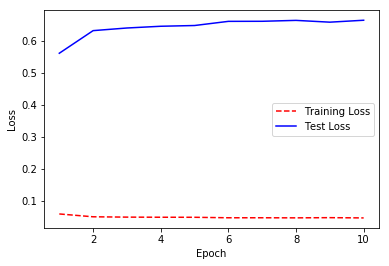

In [11]:
import matplotlib.pyplot as plt
training_loss = history.history['loss']
test_loss = history.history['acc']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [12]:

from sklearn import metrics as mt

yhat_proba = model.predict([X_test, X_test_ohe])
yhat = np.round(yhat_proba)
print(mt.accuracy_score(y_test, yhat,sample_weight=weights))

0.3499446289538348


In [40]:
inputs_2 = Input(shape=(X_train[features].shape[1],))
inputs_wide_2 = Input(shape=(X_train_ohe.shape[1],))
output_wide_2 = Dense(units=20, activation='relu')(inputs_wide_2)
output_wide_2 = Dense(3, activation='relu')(output_wide_2)

x = Dense(units=50, activation='relu')(inputs_2)
x = Dense(units=34, activation='relu')(x)
x = Dense(units=30, activation='relu')(x)
x = Dense(units=26, activation='relu')(x)
x = Dense(units=22, activation='relu')(x)
x = Dense(units=20, activation='relu')(x)
x = Dropout(.15)(x)
x = Dense(units=18, activation='relu')(x)
x = Dropout(.2)(x)
output_deep_2 = Dense(16, activation ='sigmoid')(x)

final_branch = concatenate([output_wide_2, output_deep_2], name='concat_1')
final_branch = Dense(16,activation='relu')(final_branch)
final_branch = Dropout(.3)(final_branch)
final_branch = Dense(13, activation='relu')(final_branch)
final_branch = Dense(units=10, activation='softmax', name = 'combined')(final_branch)

model = Model(inputs = [inputs_2, inputs_wide_2], outputs = final_branch)
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           (None, 17)           0                                            
__________________________________________________________________________________________________
dense_236 (Dense)               (None, 50)           900         input_44[0][0]                   
__________________________________________________________________________________________________
dense_237 (Dense)               (None, 34)           1734        dense_236[0][0]                  
__________________________________________________________________________________________________
dense_238 (Dense)               (None, 30)           1050        dense_237[0][0]                  
__________________________________________________________________________________________________
dense_239 

In [16]:
history = model.fit([X_train, X_train_ohe] ,y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
1283508/1283508 [==============================] - 154s 120us/step - loss: 0.0511 - acc: 0.6250
Epoch 2/10
1283508/1283508 [==============================] - 100s 78us/step - loss: 0.0445 - acc: 0.6779
Epoch 3/10
1283508/1283508 [==============================] - 86s 67us/step - loss: 0.0434 - acc: 0.6864
Epoch 4/10
1283508/1283508 [==============================] - 83s 65us/step - loss: 0.0425 - acc: 0.6924
Epoch 5/10
1283508/1283508 [==============================] - 83s 65us/step - loss: 0.0457 - acc: 0.6643
Epoch 6/10
1283508/1283508 [==============================] - 84s 65us/step - loss: 0.0456 - acc: 0.6699
Epoch 7/10
1283508/1283508 [==============================] - 84s 66us/step - loss: 0.0446 - acc: 0.6761
Epoch 8/10
1283508/1283508 [==============================] - 84s 66us/step - loss: 0.0482 - acc: 0.6490
Epoch 9/10
1283508/1283508 [==============================] - 83s 65us/step - loss: 0.0454 - acc: 0.6735
Epoch 10/10
1283508/1283508 [=======================

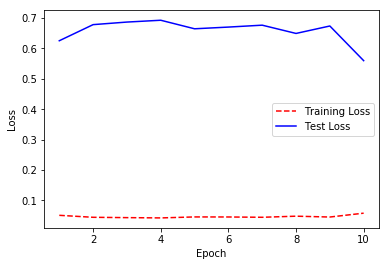

In [17]:
import matplotlib.pyplot as plt
training_loss = history.history['loss']
test_loss = history.history['acc']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [18]:

from sklearn import metrics as mt
from sklearn.metrics import confusion_matrix

yhat_proba = model.predict([X_test, X_test_ohe])
yhat = np.round(yhat_proba)
print(mt.accuracy_score(y_test, yhat,sample_weight=weights))

0.31270095475860915


In [64]:
inputs = Input(shape=(X_train[features].shape[1],))

x = Dense(units=50, activation='relu')(inputs)
x = Dense(units=34, activation='relu')(x)
x = Dense(units=30, activation='relu')(x)
x = Dense(units=26, activation='relu')(x)
x = Dense(units=22, activation='relu')(x)
x = Dropout(.15)(x)

x = Dense(units=20, activation='relu')(x)
x = Dropout(.15)(x)
x = Dense(units=18, activation='relu')(x)
x = Dropout(.15)(x)
output= Dense(10, activation ='softmax')(x)


model_mlp = Model(inputs = inputs, outputs = output)
model_mlp.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['accuracy'])
model_mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        (None, 17)                0         
_________________________________________________________________
dense_342 (Dense)            (None, 50)                900       
_________________________________________________________________
dense_343 (Dense)            (None, 34)                1734      
_________________________________________________________________
dense_344 (Dense)            (None, 30)                1050      
_________________________________________________________________
dense_345 (Dense)            (None, 26)                806       
_________________________________________________________________
dense_346 (Dense)            (None, 22)                594       
_________________________________________________________________
dropout_93 (Dropout)         (None, 22)                0         
__________

In [65]:
history = model_mlp.fit(X_train ,y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
1283508/1283508 [==============================] - 167s 130us/step - loss: 0.0463 - acc: 0.6641
Epoch 2/10
1283508/1283508 [==============================] - 115s 90us/step - loss: 0.0408 - acc: 0.7039
Epoch 3/10
1283508/1283508 [==============================] - 104s 81us/step - loss: 0.0398 - acc: 0.7108
Epoch 4/10
1283508/1283508 [==============================] - 103s 80us/step - loss: 0.0396 - acc: 0.7125
Epoch 5/10
1283508/1283508 [==============================] - 103s 81us/step - loss: 0.0394 - acc: 0.7137
Epoch 6/10
1283508/1283508 [==============================] - 104s 81us/step - loss: 0.0393 - acc: 0.7150
Epoch 7/10
1283508/1283508 [==============================] - 104s 81us/step - loss: 0.0399 - acc: 0.7100
Epoch 8/10
1283508/1283508 [==============================] - 102s 80us/step - loss: 0.0405 - acc: 0.7049
Epoch 9/10
1283508/1283508 [==============================] - 102s 79us/step - loss: 0.0403 - acc: 0.7070
Epoch 10/10
1283508/1283508 [================

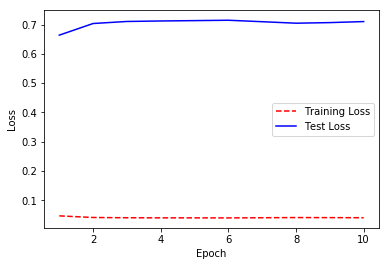

In [66]:
import matplotlib.pyplot as plt
training_loss = history.history['loss']
test_loss = history.history['acc']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
